In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import seaborn as sns
import matplotlib.pyplot as plt 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
import warnings
warnings.filterwarnings('ignore')
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pune-restaurants-zomato/zomato_outlet_final.csv


Reference - 

1. https://www.kaggle.com/shahules/zomato-complete-eda-and-lstm-model

2. https://www.kaggle.com/parthsharma5795/finding-the-best-restaurants-in-bangalore

Breakdown of this notebook:
Loading the dataset: Load the data and import the libraries.
**Data Cleaning:**
1. Cleaning column values.
2. Extracting digits for certain columns like Reviews, cost.
3. Dropping duplicates values.
4. Data Visualization: Using plots to find relations between the features.


In [2]:
zomato = pd.read_csv('/kaggle/input/pune-restaurants-zomato/zomato_outlet_final.csv', delimiter=',')
zomato.head(n=2)

,link,rest_name,rest_type,loc,dine_rating,dine_reviews,delivery_rating,delivery_reviews,cuisine,cost,liked
0,https://www.zomato.com/pune/mix@36-the-westin-...,Mix@36 - The Westin\r\r\n ...,Lounge,"The Westin, Mundhwa",4.2,(707 Reviews),NaN,NaN,"North Indian,Continental,Asian,Finger Food,","Rs. 4,300","Cocktails, Chaat, Beer"
1,https://www.zomato.com/pune/kangan-the-westin-...,Kangan - The Westin\r\r\n ...,Fine Dining,"The Westin, Mundhwa",4.1,(344 Reviews),NaN,NaN,"North Indian,Mughlai,","Rs. 3,500","Biryani, Veg Platter, Dal Makhani, Butter Chic..."


# Data Cleaning

In [3]:
'Cleaning Data'

'Function to remove special characters from name'
def clean_data(cols, str_to_replace):
           
    for col in cols:
        zomato[col] = [str(x).replace(str_to_replace,"") for x in zomato[col]]    
        
    return zomato

def extract_digit(cols):
    
    for col in cols:
        zomato[col] = zomato[col].str.extract(r'(\d+)', expand=True)
        
    return zomato
'Calling our functions'
zomato = clean_data(['rest_name'], '\r\r\n')
zomato = clean_data(['cost', 'dine_reviews', 'delivery_reviews'], ",")
zomato = extract_digit(['cost', 'dine_reviews', 'delivery_reviews'])

In [4]:
zomato.head(n=3)

,link,rest_name,rest_type,loc,dine_rating,dine_reviews,delivery_rating,delivery_reviews,cuisine,cost,liked
0,https://www.zomato.com/pune/mix@36-the-westin-...,Mix@36 - The Westin ...,Lounge,"The Westin, Mundhwa",4.2,707,NaN,NaN,"North Indian,Continental,Asian,Finger Food,",4300,"Cocktails, Chaat, Beer"
1,https://www.zomato.com/pune/kangan-the-westin-...,Kangan - The Westin ...,Fine Dining,"The Westin, Mundhwa",4.1,344,NaN,NaN,"North Indian,Mughlai,",3500,"Biryani, Veg Platter, Dal Makhani, Butter Chic..."
2,https://www.zomato.com/pune/coriander-kitchen-...,Coriander Kitchen - Conrad Pune ...,Fine Dining,"Conrad Pune, Bund Garden Road",4.5,541,NaN,NaN,"Mediterranean,Asian,North Indian,",3200,"Pasta, Panipuri, Waffles, Pizza, Salad, Chaat,..."


In [5]:
'Checking for duplicates'
zomato.drop_duplicates("link",keep='first',inplace=True)
zomato.reset_index(drop=True,inplace=True)
zomato.shape

(4930, 11)

In [6]:
print("Percentage null or na values in df")
((zomato.isnull() | zomato.isna()).sum() * 100 / zomato.index.size).round(2)

Percentage null or na values in df


link                 0.00
rest_name            0.00
rest_type           20.81
loc                  0.00
dine_rating         11.81
dine_reviews        11.81
delivery_rating     54.73
delivery_reviews    54.73
cuisine              0.00
cost                 0.00
liked               54.48
dtype: float64

In [7]:
'Checking data type of columns'
zomato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   link              4930 non-null   object 
 1   rest_name         4930 non-null   object 
 2   rest_type         3904 non-null   object 
 3   loc               4930 non-null   object 
 4   dine_rating       4348 non-null   float64
 5   dine_reviews      4348 non-null   object 
 6   delivery_rating   2232 non-null   float64
 7   delivery_reviews  2232 non-null   object 
 8   cuisine           4930 non-null   object 
 9   cost              4930 non-null   object 
 10  liked             2244 non-null   object 
dtypes: float64(2), object(9)
memory usage: 423.8+ KB


In [8]:
'Converting Reviews and cost to integer'
zomato.replace('NA', np.nan)
def convert_cols(cols):
    
    for col in cols:
        zomato[col] = zomato[col].astype(float)
        
    return zomato

zomato = convert_cols(['dine_reviews', 'delivery_reviews', 'cost'])

# ** Exploratory Data Analysis**

# Which chain has maximum no of outlets in Pune?

Text(0.5, 0, 'Number of outlets')

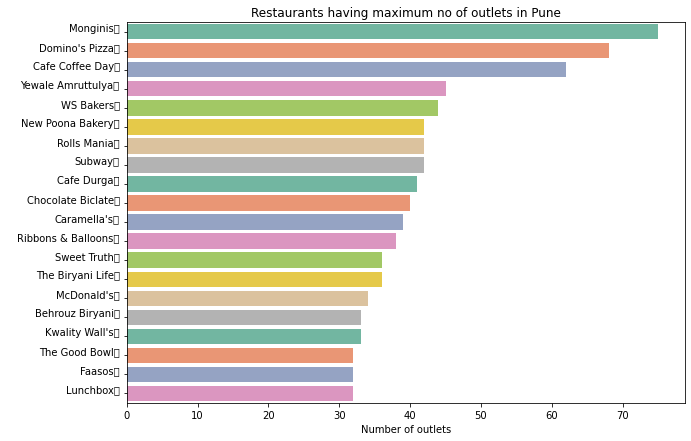

In [9]:
plt.figure(figsize=(10,7))
chains=zomato['rest_name'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='Set2')
plt.title("Restaurants having maximum no of outlets in Pune")
plt.xlabel("Number of outlets")

# Food Street in Pune?

Text(0.5, 1.0, 'No of restaurants in Locality')

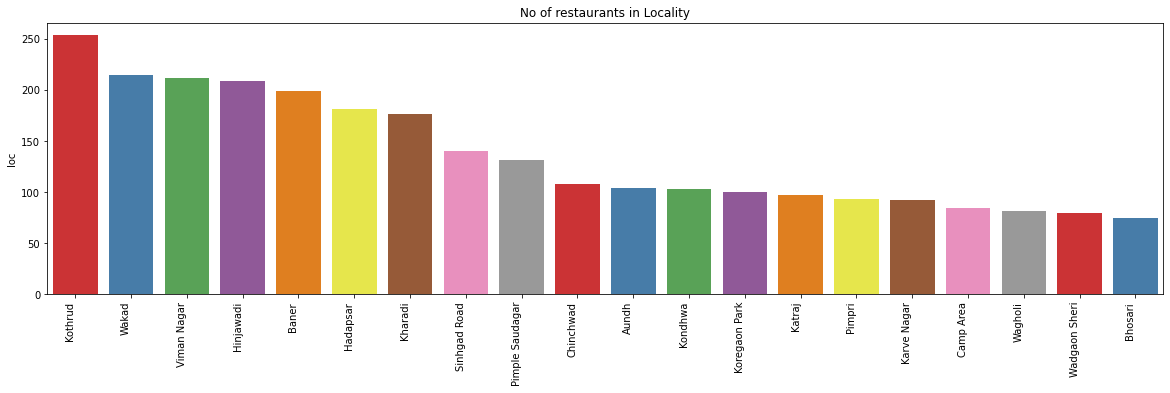

In [10]:
plt.figure(figsize=(20,5))
locations=zomato['loc'].value_counts()[:20]
g = sns.barplot(locations.index,locations,palette="Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g
plt.title("No of restaurants in Locality")

# Most preferred restaurant type in Pune?


Text(0.5, 0, 'Number of restaurants')

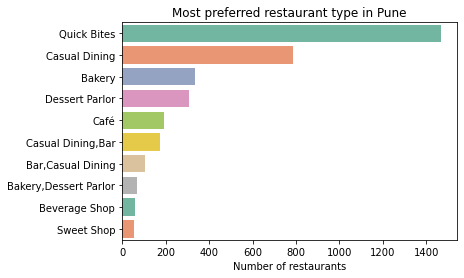

In [11]:
r_type =zomato['rest_type'].value_counts()[:10]
sns.barplot(x=r_type,y=r_type.index,palette='Set2')
plt.title("Most preferred restaurant type in Pune")
plt.xlabel("Number of restaurants")

['cuisine', 'liked']


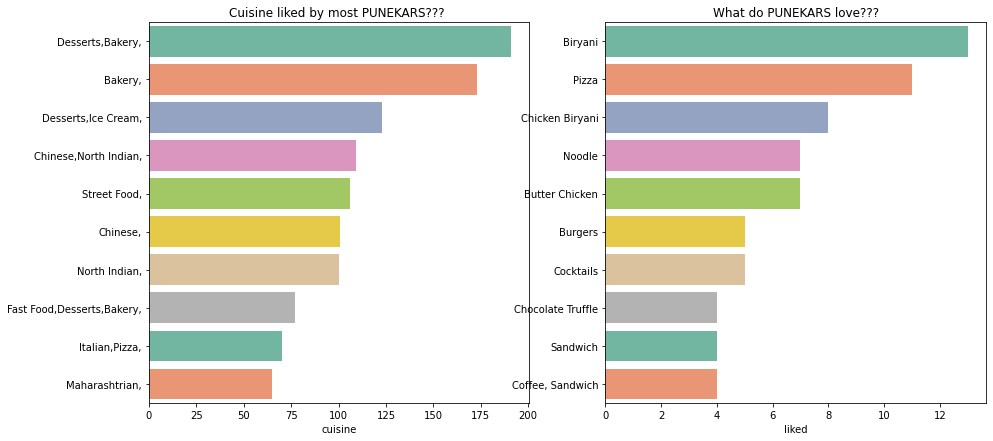

In [12]:
'Defining a function to plot graphs for top 10 attributes'


def bar_plot_h(cols, titles):
    print(cols)
    n=len(cols)
    f, axes = plt.subplots(1, 2, figsize=(15, 7))
    for col, ax, i  in zip(cols, axes.flatten()[:n], range(0,n)):
        c=zomato[col].value_counts()[:10]
        sns.barplot(c, c.index,ax = ax, palette = 'Set2').set_title(titles[i])
        
    
       
    
bar_plot_h(['cuisine', 'liked'], ["Cuisine liked by most PUNEKARS??? ", "What do PUNEKARS love???"])  

# Generating wordclouds for most liked dish 

There are 160709 words in the combination of all review.


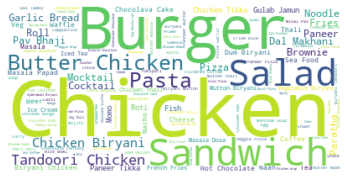

In [13]:
'Converting dish liked into 1 text item'
text = " ".join(str(dish) for dish in zomato.liked)
print ("There are {} words in the combination of all review.".format(len(text)))
stopwords = ['NaN']
wordcloud = WordCloud( stopwords = stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Forming wordclouds for 5 restaurant type


In [14]:
'Printing Restuarnat types'
rest=zomato['rest_type'].value_counts().index
print(rest)

Index(['Quick Bites', 'Casual Dining', 'Bakery', 'Dessert Parlor', 'Café',
       'Casual Dining,Bar', 'Bar,Casual Dining', 'Bakery,Dessert Parlor',
       'Beverage Shop', 'Sweet Shop', 'Food Court', 'Lounge', 'Bar',
       'Fine Dining', 'Lounge,Casual Dining', 'Café,Dessert Parlor',
       'Bakery,Quick Bites', 'Sweet Shop,Quick Bites', 'Food Truck',
       'Dessert Parlor,Bakery', 'Dessert Parlor,Quick Bites',
       'Pub,Casual Dining', 'Dhaba', 'Café,Bakery', 'Bakery,Café',
       'Beverage Shop,Quick Bites', 'Café,Casual Dining', 'Fine Dining,Bar',
       'Irani Cafe', 'Dessert Parlor,Beverage Shop', 'Quick Bites,Food Court',
       'Quick Bites,Beverage Shop', 'Beverage Shop,Dessert Parlor',
       'Casual Dining,Café', 'Quick Bites,Dessert Parlor', 'Pub', 'Lounge,Bar',
       'Kiosk', 'Club', 'Dessert Parlor,Café', 'Casual Dining,Lounge', 'Mess',
       'Microbrewery', 'Quick Bites,Sweet Shop', 'Café,Quick Bites',
       'Bhojanalya', 'Food Court,Quick Bites', 'Bar,Pub',
     

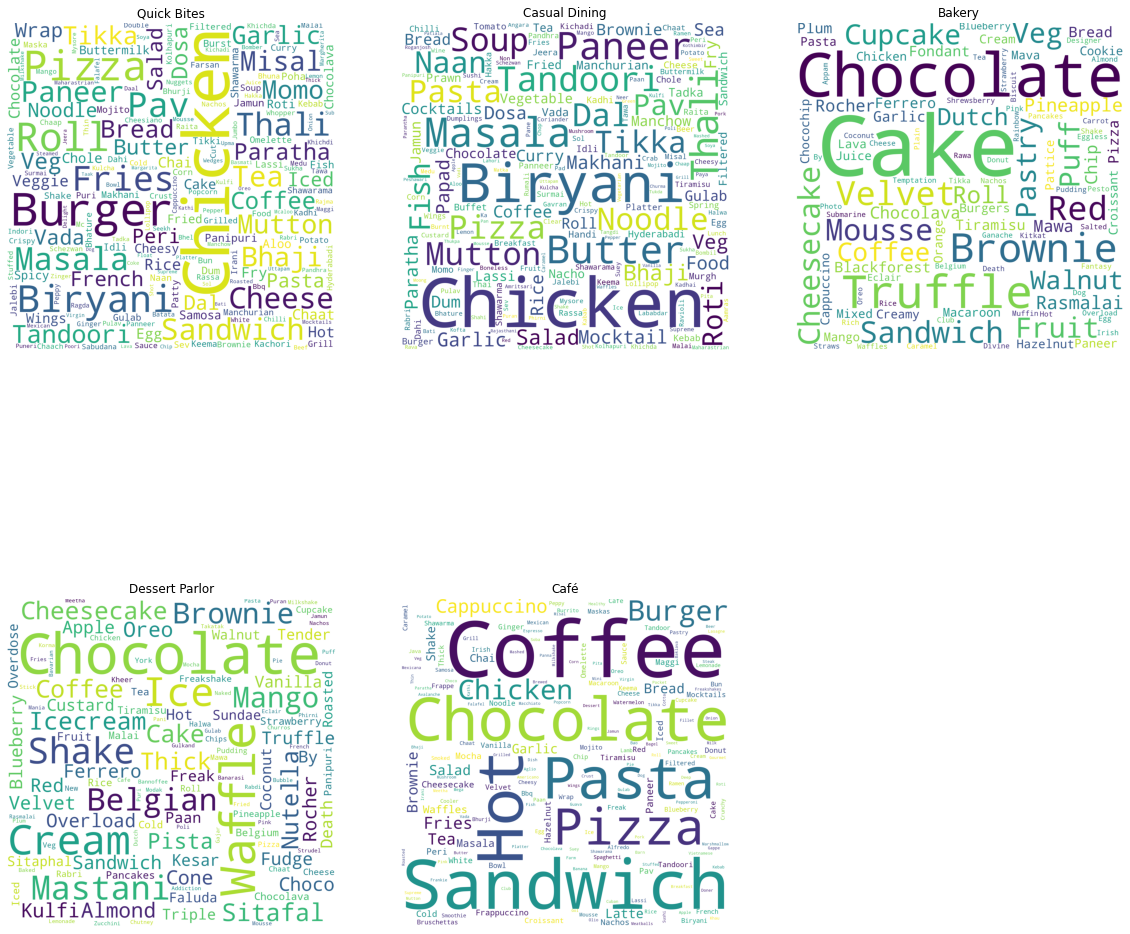

In [15]:
rest=zomato['rest_type'].value_counts()[:5].index
def produce_wordcloud(df,rest):
    stopwords = ['NaN']
    plt.figure(figsize=(20,30))
    for i,r in enumerate(rest):
        plt.subplot(3,3,i+1)
        corpus=df[df['rest_type']==r]['liked'].tolist()
        corpus=','.join(str(x)  for x in corpus )
        wordcloud = WordCloud(stopwords = stopwords,max_font_size=None, background_color='white', collocations=False,
                      width=1500, height=1500).generate(corpus)
        plt.imshow(wordcloud)
        plt.title(r)
        plt.axis("off")
        

        
        
produce_wordcloud(zomato,rest)

# Most voted restaurants in Pune?


['cost', 'dine_reviews']


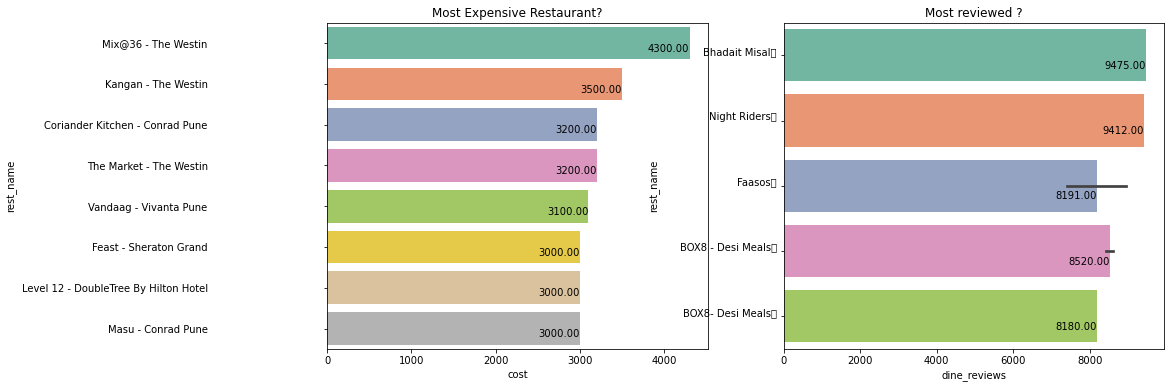

In [16]:

def bar_plot(cols, titles):
    print(cols)
    n=len(cols)
    f, axes = plt.subplots(1, 2, figsize=(15, 6))
    for col, ax, i  in zip(cols, axes.flatten()[:n], range(0,n)):
        c=zomato[['rest_name',col]].sort_values(by = col,ascending = False)[:8]
        g = sns.barplot(x = c[col], y =c['rest_name'],ax = ax, palette = 'Set2').set_title(titles[i])
        'For showing values in barplot'
        for p in ax.patches:
            width = p.get_width()
            ax.text(width -1.5  ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}'.format(width),
                ha="right")

bar_plot( [ 'cost', 'dine_reviews'], ["Most Expensive Restaurant?", "Most reviewed ?"])           

Text(0.5, 1.0, 'Cost Distrubution for all restaurants')

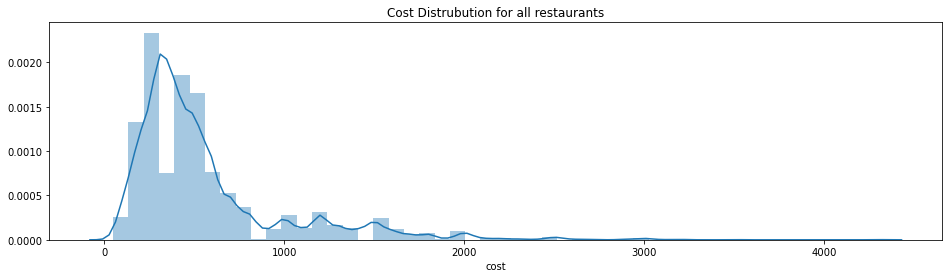

In [17]:
'Cost Distribution '
fig, ax = plt.subplots(figsize=[16,4])
sns.distplot(zomato['cost'],ax=ax)
ax.set_title('Cost Distrubution for all restaurants')

# Inferences - 

More than 50% restaurants have rating between 3.5 and 4

In [18]:
zomato.describe()

,dine_rating,dine_reviews,delivery_rating,delivery_reviews,cost
count,4348.000000,4348.000000,2232.000000,2232.000000,4930.000000
mean,3.639282,417.474241,3.821416,1473.049731,564.076876
std,0.489835,886.960664,0.348318,1988.075715,441.885009
min,2.000000,0.000000,2.000000,0.000000,50.000000
25%,3.300000,33.000000,3.600000,164.000000,300.000000
50%,3.700000,119.000000,3.900000,594.000000,400.000000
75%,4.000000,381.250000,4.000000,1908.750000,600.000000
max,4.900000,9475.000000,4.800000,9980.000000,4300.000000


Text(0, 0.5, 'count')

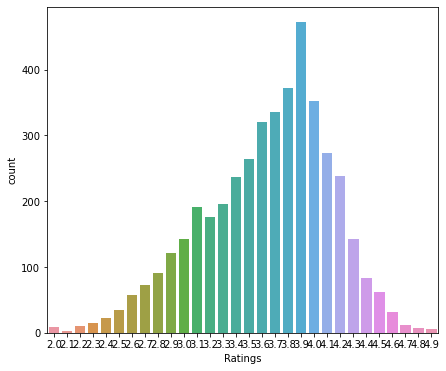

In [19]:
'--------------Rating Distribution----------'

plt.figure(figsize=(7,6))
rating=zomato['dine_rating'].value_counts()
sns.barplot(x=rating.index,y=rating)
plt.xlabel("Ratings")
plt.ylabel('count')

# Localities for Most Expensive 20 restaurants?

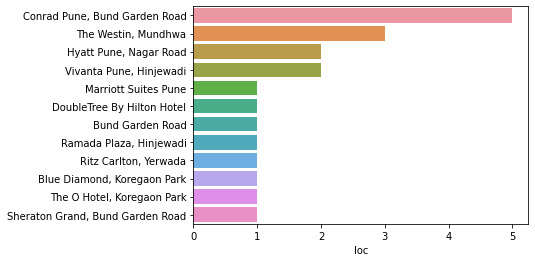

In [20]:
most_voted = zomato[['loc','cost']].sort_values(by = 'cost', ascending = False)[:20]
xy = most_voted['loc'].value_counts()
sns.barplot(x = xy, y = xy.index)

# Most Popular Cuisine for a locality?

In [21]:
popular_cuis=zomato.groupby(['loc','cuisine']).agg('count')
data=popular_cuis.groupby(['loc'],
                as_index=False).apply(lambda x : x.sort_values(by="rest_name",ascending=False).head(3))['rest_name'].reset_index().rename(columns={'rest_name':'count'})

data.head(n=10)

,level_0,loc,cuisine,count
0,0,"Hotel Satish Executive, Wakad","Continental,Chinese,North Indian,South Indian,",1
1,1,"ABC Farms,Mundhwa","Continental,North Indian,Iranian,",1
2,2,"Aditi Mall, Baner Road","Bakery,",1
3,2,"Aditi Mall, Baner Road","Biryani,North Indian,Mughlai,",1
4,2,"Aditi Mall, Baner Road","Fast Food,Street Food,",1
5,3,"Aditya Shagun Mall, Bavdhan","Continental,North Indian,Asian,",1
6,3,"Aditya Shagun Mall, Bavdhan","Mediterranean,Italian,",1
7,3,"Aditya Shagun Mall, Bavdhan","Salad,Sandwich,Healthy Food,Fast Food,",1
8,4,Akurdi,"Bakery,",2
9,4,Akurdi,"Chinese,Maharashtrian,North Indian,",2


# Best cheap Restaurants?

Criteria - 
1. Cost < 1000
2. Rating (dine or delivery) > 4.3
3. No of reviews( dine or delivery) > 4000


In [22]:
cheap_rest=zomato[['rest_name','cost', 'loc','rest_type','cuisine', 'delivery_rating', 'dine_rating', 'delivery_reviews', 'dine_reviews']]
cheap_rest=cheap_rest[(cheap_rest['cost'] <1000) & ( (cheap_rest['dine_rating'] > 4.3 )| (cheap_rest['delivery_rating'] > 4.3)) &   ((cheap_rest['delivery_reviews'] > 4000) | (cheap_rest['dine_reviews'] >4000))]
cheap_rest.head(n=10)



,rest_name,cost,loc,rest_type,cuisine,delivery_rating,dine_rating,delivery_reviews,dine_reviews
763,Vaishali\r\n,500.0,FC Road,Casual Dining,"Beverages,Fast Food,Sandwich,South Indian,",4.6,4.5,9562.0,5745.0
843,Momo's Corrner\r\n ...,200.0,Koregaon Park,Quick Bites,"Beverages,Tibetan,Momos,",3.9,4.6,4820.0,707.0
862,Domino's Pizza\r\n ...,400.0,Senapati Bapat Road,Quick Bites,"Italian,Pizza,",4.4,3.6,8378.0,522.0
878,Domino's Pizza\r\n ...,400.0,Hadapsar,Quick Bites,"Italian,Pizza,",4.4,3.0,7604.0,337.0
946,Cafe Goodluck\r\n ...,800.0,Deccan Gymkhana,Quick Bites,"Desserts,Biryani,Maharashtrian,Mughlai,North I...",3.9,4.4,30.0,7077.0
1012,Cafe Samosa Corner\r\n ...,100.0,Kondhwa,Quick Bites,"Street Food,",4.4,4.0,6526.0,264.0
1182,The Momo Panda\r\n ...,300.0,Kothrud,Quick Bites,"Momos,",4.5,4.3,7862.0,507.0
1242,Bhadait Misal\r\n ...,150.0,Erandwane,Quick Bites,"Street Food,",NaN,4.4,NaN,9475.0
1302,Darshan\r\n,700.0,Deccan Gymkhana,Casual Dining,"Desserts,Street Food,Fast Food,Mexican,Chinese...",4.0,4.5,3685.0,4672.0
1346,Rolls Mania\r\n ...,300.0,"Destination Centre, Magarpatta",Quick Bites,"Beverages,Fast Food,Rolls,",4.4,4.1,8183.0,566.0


# Highly Rated and Highly reviewed Expensive restaurants

In [23]:
exp_rest=zomato[['rest_name','cost', 'loc','rest_type','cuisine', 'delivery_rating', 'dine_rating', 'delivery_reviews', 'dine_reviews']]
exp_rest=exp_rest[(exp_rest['cost'] >2500) & ( (exp_rest['dine_rating'] > 4.0 )| (exp_rest['delivery_rating'] > 4.0))&   ((exp_rest['delivery_reviews'] > 400) | (exp_rest['dine_reviews'] >400))].sort_values(by=['dine_reviews'], ascending = False)
exp_rest.head()


,rest_name,cost,loc,rest_type,cuisine,delivery_rating,dine_rating,delivery_reviews,dine_reviews
17,Oak Lounge - Marriott Suites Pune ...,2700.0,Marriott Suites Pune,Lounge,"Finger Food,",NaN,4.2,NaN,845.0
5,Baan Tao - Hyatt Pune ...,3000.0,"Hyatt Pune, Nagar Road",Fine Dining,"Salad,Asian,Malaysian,Vietnamese,Thai,Chinese,",NaN,4.5,NaN,739.0
0,Mix@36 - The Westin ...,4300.0,"The Westin, Mundhwa",Lounge,"North Indian,Continental,Asian,Finger Food,",NaN,4.2,NaN,707.0
18,The Cafè - Hyatt Regency Pune ...,2600.0,"The Hyatt Regency, Nagar Road",Fine Dining,"Continental,Asian,North Indian,",NaN,4.3,NaN,675.0
8,Feast - Sheraton Grand ...,3000.0,"Sheraton Grand, Bund Garden Road",Fine Dining,"European,Asian,North Indian,",NaN,4.5,NaN,577.0


# Interesting thing to note in Expensive restaurants is that none of them provide delivery. 